In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_fine']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_fine'])
#df = df[df['y_fine'] >= 500000]
df = df[df['y_fine'] <= 70500000] # 하위 90%

In [4]:
X = df.drop('y_fine', axis=1)
y = df['y_fine']/100000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 256

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(dfc.columns[1:]),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(dfl.columns[1:]),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_3)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_3)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0825_6.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 200
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

14719


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_4)

model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), metrics=['mse', 'mae', 'mape'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     1884032     input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
______________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.1)

Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 [==============================] - 6s 5ms/sample - loss: 9252.7664 - mse: 8963.0186 - mae: 59.7702 - mape: 10112169.0000 - val_loss: 6709.8068 - val_mse: 6282.3584 - val_mae: 57.5249 - val_mape: 1922914.1250
Epoch 2/100
1076/1076 [==============================] - 0s 317us/sample - loss: 7869.1114 - mse: 7385.1284 - mae: 54.5001 - mape: 11450871.0000 - val_loss: 5686.2535 - val_mse: 5142.7710 - val_mae: 45.7931 - val_mape: 1558384.6250
Epoch 3/100
1076/1076 [==============================] - 0s 305us/sample - loss: 6908.1292 - mse: 6288.7354 - mae: 49.0638 - mape: 10403575.0000 - val_loss: 5732.5541 - val_mse: 5052.3467 - val_mae: 43.6659 - val_mape: 1576043.5000
Epoch 4/100
1076/1076 [==============================] - 0s 308us/sample - loss: 6140.6493 - mse: 5376.4678 - mae: 45.4747 - mape: 8003180.5000 - val_loss: 6862.5221 - val_mse: 6040.2729 - val_mae: 53.5154 - val_mape: 2046154.6250
Epoch 5/100
1076/1076 [=====

1076/1076 [==============================] - 0s 310us/sample - loss: 1213.0432 - mse: 557.8602 - mae: 13.7501 - mape: 1457795.7500 - val_loss: 5579.6342 - val_mse: 4952.3408 - val_mae: 39.2016 - val_mape: 1662871.2500
Epoch 69/100
1076/1076 [==============================] - 0s 308us/sample - loss: 1422.3647 - mse: 765.8408 - mae: 15.4920 - mape: 1139868.3750 - val_loss: 6072.0763 - val_mse: 5441.7676 - val_mae: 44.6254 - val_mape: 2014148.5000
Epoch 70/100
1076/1076 [==============================] - 0s 309us/sample - loss: 1360.9410 - mse: 724.8135 - mae: 15.6042 - mape: 1455820.2500 - val_loss: 5630.3245 - val_mse: 4996.0864 - val_mae: 41.4987 - val_mape: 1798901.3750
Epoch 71/100
1076/1076 [==============================] - 0s 329us/sample - loss: 1292.5377 - mse: 666.6427 - mae: 15.1727 - mape: 1319404.5000 - val_loss: 6146.4234 - val_mse: 5492.6792 - val_mae: 45.4481 - val_mape: 1949474.6250
Epoch 72/100
1076/1076 [==============================] - 0s 347us/sample - loss: 1234.24

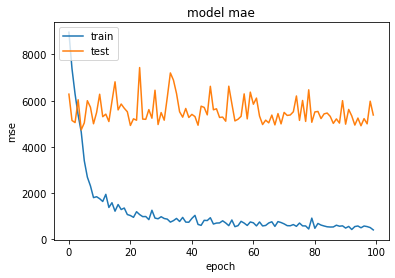

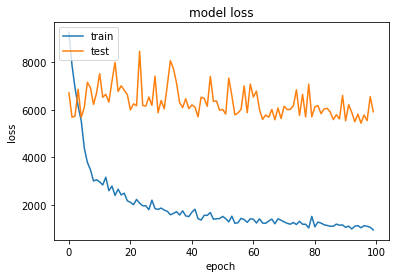

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
print("Test MAE: ", score[2])
print("Test MAPE: ", score[3])

133/133 [==============================] - 0s 1ms/sample - loss: 5605.2845 - mse: 5070.5981 - mae: 41.9078 - mape: 11123768.0000
[5605.284480733083, 5070.598, 41.90785, 11123768.0]
Test Score: 5605.284480733083
Test MSE: 5070.598
Test MAE:  41.90785
Test MAPE:  11123768.0
